In [96]:
import warnings
from yahoo_fin.stock_info import get_data
warnings.filterwarnings("ignore")
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from numpy import log
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score


In [97]:
msft = yf.Ticker("BTC")
msft.info

{'phone': '800-617-0004',
 'longBusinessSummary': 'The investment seeks current income consistent with the long term preservation of capital.\n The fund is an actively managed exchange-traded fund ("ETF") that seeks to achieve its investment objective by investing, under normal market conditions, at least 80% of its net assets (plus borrowings for investment purposes) in debt securities and in derivatives and other instruments that have economic characteristics similar to such securities. It principally invests in U.S.-dollar denominated, investment-grade securities and seeks to typically maintain a dollar-weighted average portfolio maturity of zero to ten years. The fund is non-diversified.',
 'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 99.1475,
 'open': 99.2,
 'dayLow': 99.07,
 'dayHigh': 99.1568,
 'regularMarketPreviousClose': 99.1475,
 'regularMarketOpen': 99.2,
 'regularMarketDayLow': 99.07,
 'regularMarketDayHigh': 99.1568,
 'volume': 2968,
 'regularMarketVolume': 2968,
 

In [98]:
sns.set_theme()
sns.set_context("paper")

In [99]:
stock = 'BTC'
resolution = '1d'
end_date = datetime.now()
start_date = end_date - timedelta(days=365)
def date_format(date_h):
    return date_h.strftime('%d/%m/%Y')

In [100]:
BTC_df = get_data(stock, start_date=start_date, end_date=end_date, interval=resolution, index_as_date=False)
BTC_df.head()

,date,open,high,low,close,adjclose,volume,ticker
0,2023-03-27,92.350098,92.350098,92.266602,92.266602,90.144852,114,BTC
1,2023-03-28,92.163101,92.163101,92.163101,92.163101,90.043732,10,BTC
2,2023-03-29,91.809998,91.818001,91.809998,91.815201,90.062317,752,BTC
3,2023-03-30,91.875603,91.875603,91.875603,91.875603,90.121567,2,BTC
4,2023-03-31,91.940002,92.184998,91.940002,92.184998,90.425049,106,BTC


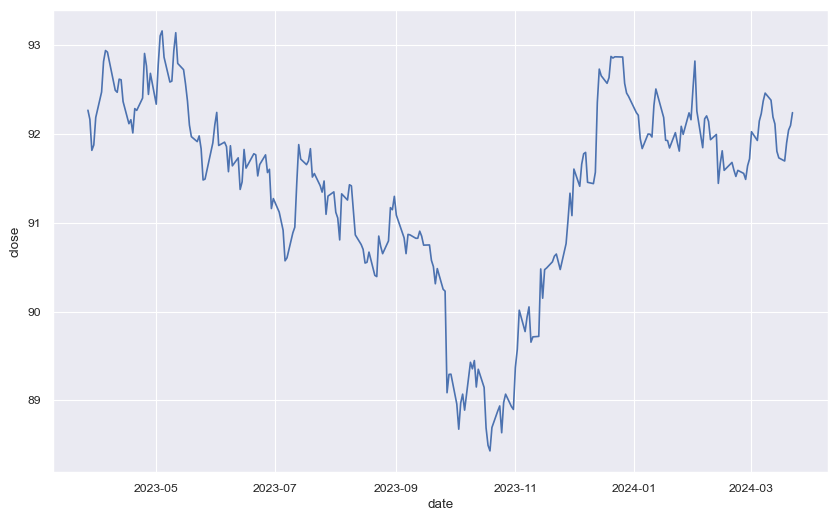

In [101]:
sns.lineplot(data=BTC_df, x=BTC_df.date, y=BTC_df.close);


Esta gráfica parece representar el precio de cierre del Bitcoin (BTC) en función del tiempo, desde mayo de 2023 hasta marzo de 2024. El eje vertical (Y) muestra el precio de cierre.
La tendencia del precio comienza con fluctuaciones menores alrededor de 93, luego desciende gradualmente hasta alcanzar un punto bajo cercano a 89 a finales de 2023. Después de este punto bajo, hay un fuerte incremento en el precio que alcanza una cota superior justo por encima de 92 a principios de 2024. Posteriormente, el precio vuelve a fluctuar pero se mantiene mayormente por encima del valor de 91 hasta marzo de 2024.

In [102]:
fig = go.Figure(data=[go.Candlestick(x = BTC_df.date,
                                     open = BTC_df.open, 
                                     high = BTC_df.high,
                                     low = BTC_df.low, 
                                     close = BTC_df.close)
                     ])
fig.update_layout(
    title="BITCOIN",
    xaxis_title="Day",
    yaxis_title="BTC-USD",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)
fig.update_layout(xaxis_rangeslider_visible=False)
fig

El grafíco de velas claramente muestra la misma tendencia del grafíco de lineas. Aquí se puede visualizar información sobre los cambios de precios que se producen en índices bursátiles de BTC

 ### Dickey-Fuller test
 
 **H_0**: la serie de tiempo no es estacionaria
 **H_1**: la serie de tiempo es estacionaria

In [103]:
result = adfuller(BTC_df.close)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.762180
p-value: 0.399393


Dado que el p_valor es > 0.05 no rechazamos nuestra hipótesis inicial con una significancia de 0.05, por tanto, esto se trata de una serie no estacionario

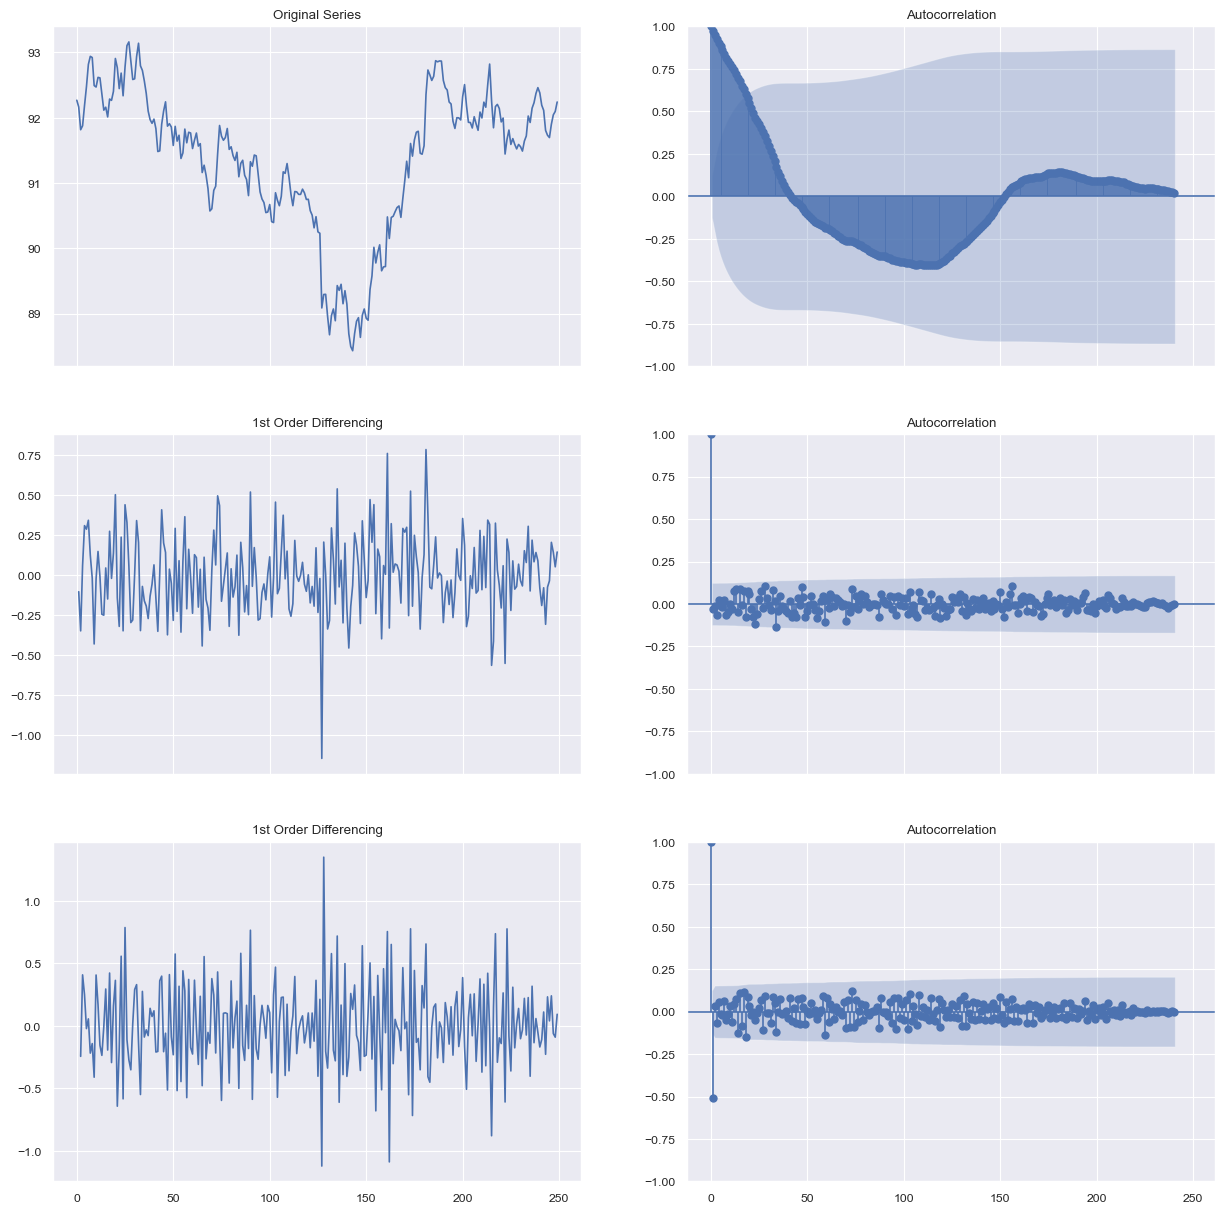

In [104]:
plt.rcParams.update({'figure.figsize': (15,15)})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(BTC_df.close); axes[0, 0].set_title('Original Series')
plot_acf(BTC_df.close, ax=axes[0, 1], lags = 240);

axes[1, 0].plot(BTC_df.close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(BTC_df.close.diff().dropna(), ax=axes[1, 1], lags = 240);

axes[2, 0].plot(BTC_df.close.diff().diff()); axes[2, 0].set_title('1st Order Differencing')
plot_acf(BTC_df.close.diff().diff().dropna(), ax=axes[2, 1], lags = 240);

Nótese el decaimiento geométrico en la primera figura de autocorrelación, que baja desde la parte positiva con una tendencia lineal, el cual se interpreta como una autocorrelación asociada a una serie de tiempo no estacionaría, como indica la prueba de Dickey-Fuller.
Al observar el gráfico de autocorrelación para la segunda diferenciación, la segunda autocorrelación entra en la zona negativa con bastante rapidez, lo que indica que la serie podría haber sido sobrediferenciada por tanto, nos quedamos con diferenciacion de primer orden

### 28 días

### Estimación de máxima verosimilitud 

In [105]:
n_BTC = len(BTC_df.close); n_test = 28
train_size = n_BTC - n_test
train = BTC_df.close[:train_size]
dates_train = BTC_df.date[:train_size]
test_2w = BTC_df.close[train_size:train_size + n_test] 
dates_2w = BTC_df.date[train_size:train_size + n_test] 
print("train:", train.shape)
print("test_2w:", test_2w.shape)

train: (222,)
test_2w: (28,)


In [106]:
train_df = BTC_df[["close"]][:train_size]
test_2w_df = BTC_df[["close"]][train_size:train_size + n_test] 
test_2w_df

,close
222,91.443100
223,91.668602
224,91.810097
225,91.589897
226,91.679100
227,91.591904
228,91.521301
229,91.589897
230,91.555298
231,91.487999


### ARIMA

In [107]:
best_aic = np.inf
best_bic = np.inf

best_order = None
best_mdl = None

pq_rng = range(5)
d_rng  = range(3)

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                # print(i, d, j)
                tmp_mdl = ARIMA(train, order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 18.25035 | order: (0, 1, 0)


 el mejor modelo ARIMA encontrado tiene un AIC de aproximadamente 32.54778 con un orden de (0, 1, 0). Esto sugiere que el mejor modelo es un ARIMA simple que solo necesita diferenciación de primer orden para hacer la serie estacionaria, y no necesita términos AR (autoregresivos) ni MA (de media móvil)

#### Auto ARIMA


In [108]:
model = pm.arima.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23.449, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20.245, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22.062, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22.050, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18.250, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.367 seconds


El modelo con el valor más bajo de AIC es ARIMA(0,1,0)(0,0,0)[0], con un AIC de 32.54778. Dado que los otros modelos tienen valores más altos de AIC, el modelo ARIMA(0,1,0) sin términos estacionales es considerado el mejor modelo entre los evaluados. 

In [109]:
model = ARIMA(train, order=best_order)
model_fit = model.fit()

In [110]:
best_aic = np.inf
best_bic = np.inf
best_hqic = np.inf


best_aic_order = None
best_bic_order = None
best_hqic_order = None

pq_rng = range(5) 
d_rng = range(3)   
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
            
                tmp_mdl = ARIMA(train, order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                tmp_bic = tmp_mdl.bic
                tmp_hqic = tmp_mdl.hqic
                

                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_aic_order = (i, d, j)
                
                
                if tmp_bic < best_bic:
                    best_bic = tmp_bic
                    best_bic_order = (i, d, j)
         
                if tmp_hqic < best_hqic:
                    best_hqic = tmp_hqic
                    best_hqic_order = (i, d, j)
                    
            except: 
                continue


results_df = pd.DataFrame({
    'AIC': [best_aic],
    'BIC': [best_bic],
    'HQIC': [best_hqic],
    'AIC Order': [best_aic_order],
    'BIC Order': [best_bic_order],
    'HQIC Order': [best_hqic_order]
})

print(results_df)


         AIC        BIC       HQIC  AIC Order  BIC Order HQIC Order
0  18.250346  21.648509  19.622463  (0, 1, 0)  (0, 1, 0)  (0, 1, 0)


AIC (32.547778): Este es el más bajo de los tres criterios, lo cual es favorable, ya que indica que el modelo tiene un buen equilibrio entre la bondad de ajuste y la simplicidad. En el contexto de las finanzas y los mercados de criptomonedas, que son notoriamente volátiles y ruidosos, un AIC bajo sugiere que el modelo podría generalizar bien en nuevos datos, evitando el sobreajuste.

BIC (35.950456): El BIC es más alto que el AIC, lo que es típico porque el BIC penaliza los modelos con más parámetros más fuertemente que el AIC. A pesar de ser más alto, el hecho de que no sea significativamente mayor que el AIC sugiere que la penalización adicional por la complejidad del modelo no está sugiriendo que el modelo sea excesivamente complejo. Esto es positivo en el modelado de series de tiempo financieras, ya que los modelos más sencillos son menos propensos a sobreajustarse a las peculiaridades de los datos históricos.

HQIC (33.921568): El HQIC se sitúa entre el AIC y el BIC en términos de valor. Al igual que el BIC, también penaliza la complejidad del modelo, pero no tanto como el BIC. Un HQIC relativamente bajo junto con un AIC bajo sugiere nuevamente que el modelo ha encontrado una buena mezcla de complejidad y capacidad de ajuste.

TODOS COICIDEN CON EL MISMO ORDEN

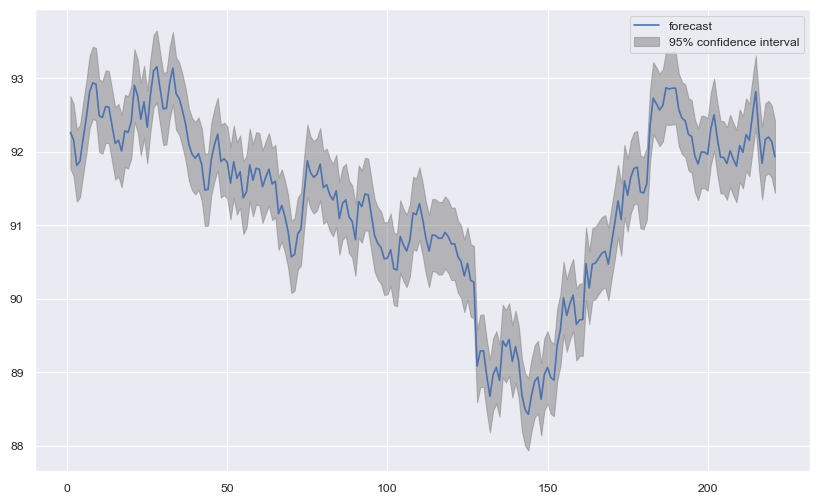

In [111]:
plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots();
plot_predict(model_fit, 1, ax=ax);
plt.show();

el modelo sigue de cerca la serie de tiempo real, indicando que ha aprendido bien la tendencia y la variabilidad de los datos de entrenamiento. El intervalo de confianza se amplía a medida que nos alejamos de los puntos de datos conocidos, lo que es típico, ya que hay más incertidumbre en las predicciones a medida que se intenta predecir más lejos en el futuro.

El descenso general en los valores a lo largo del tiempo en la serie de tiempo sugiere una tendencia decreciente en los datos. El modelo parece capturar esta tendencia, ya que las predicciones también muestran un descenso.

### Rolling

In [112]:
def arima_rolling(history, test):
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    return predictions
test_2wl = test_2w.tolist()
yhat_2w  = arima_rolling(train.tolist(), test_2wl)

predicted=91.994003, expected=91.443100
predicted=91.443100, expected=91.668602
predicted=91.668602, expected=91.810097
predicted=91.810097, expected=91.589897
predicted=91.589897, expected=91.679100
predicted=91.679100, expected=91.591904
predicted=91.591904, expected=91.521301
predicted=91.521301, expected=91.589897
predicted=91.589897, expected=91.555298
predicted=91.555298, expected=91.487999
predicted=91.487999, expected=91.640701
predicted=91.640701, expected=91.719704
predicted=91.719704, expected=92.025002
predicted=92.025002, expected=91.926300
predicted=91.926300, expected=92.144997
predicted=92.144997, expected=92.228401
predicted=92.228401, expected=92.370003
predicted=92.370003, expected=92.459801
predicted=92.459801, expected=92.379997
predicted=92.379997, expected=92.190598
predicted=92.190598, expected=92.111900
predicted=92.111900, expected=91.805000
predicted=91.805000, expected=91.730202
predicted=91.730202, expected=91.695000
predicted=91.695000, expected=91.900002


### Tablas de error

In [113]:
def forecast_accuracy(forecast, actual, str_name):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    mae = np.mean(np.abs(forecast - actual))                 # MAE
    rmse = np.mean((forecast - actual)**2)**.5               # RMSE
    mse = np.mean((forecast - actual)**2)                    # MSE
    r2 = r2_score(forecast, actual)
    
    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse],
                           'R2': [r2]},
                          index=[str_name])
    
    return df_acc
forecast_accuracy(np.array(test_2wl), np.array(yhat_2w), "21 días")

,MAE,MSE,MAPE,RMSE,R2
21 días,0.144079,0.032313,0.001568,0.179758,0.632059


-  Un MAE de 0.137486 sugiere que, en promedio, el modelo se equivoca por aproximadamente 0.137486 unidades en sus predicciones. 
-  Un MSE de 0.021158 es relativamente bajo, lo que podría indicar que el modelo está realizando predicciones precisas.
-  Un MAPE de 0.001332, o 0.1332%, es bastante bajo, lo que indica que el modelo es muy preciso en términos porcentuales. 
- El RMSE es la raíz cuadrada del MSE. Proporciona una medida de la magnitud del error en las mismas unidades que los datos de predicción. Un RMSE de 0.145459 no es muy alto, lo cual es bueno.
- Un R2 de 0.77959 significa que aproximadamente el 77.959% de la variabilidad de los datos reales se explica por el modelo. 

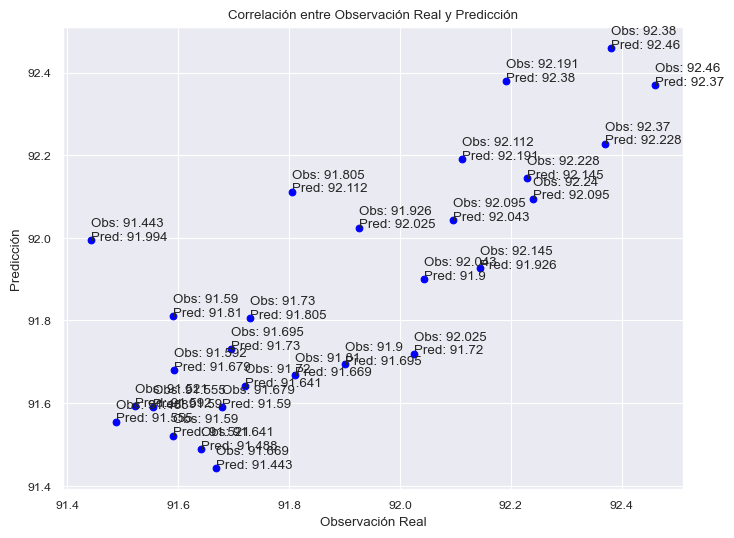

In [114]:
plt.figure(figsize=(8, 6))
plt.scatter(test_2wl, yhat_2w, color='blue')
plt.xlabel('Observación Real')
plt.ylabel('Predicción')
plt.title('Correlación entre Observación Real y Predicción')

for i in range(len(test_2wl)):
    plt.annotate(f'Obs: {round(test_2wl[i], 3)}\nPred: {round(yhat_2w[i], 3)}', (test_2wl[i], yhat_2w[i]))

plt.grid(True)
plt.show()

la distibucion de los datos predichos vs observados dan cuenta del ajuste del modelo. Dado que los valores son muy cercanos, la distribucion es proporcional. 

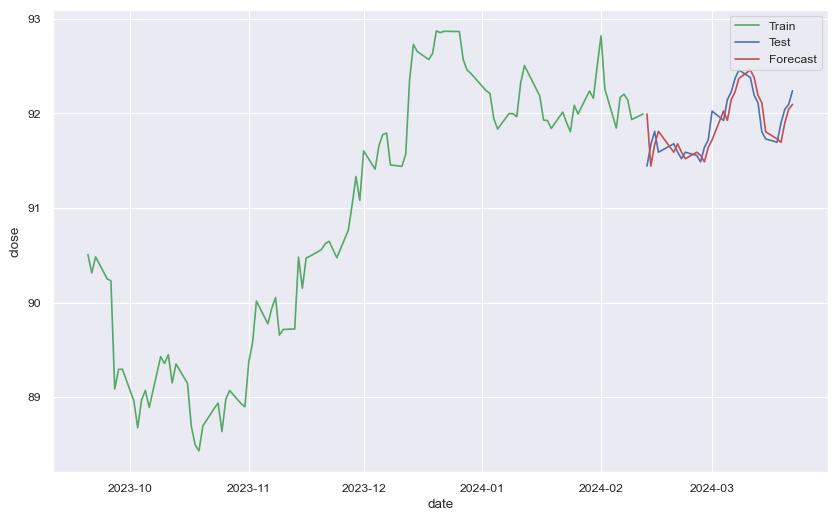

In [115]:
ax = sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g')
sns.lineplot(x=dates_2w, y=test_2wl, label="Test", color='b')
sns.lineplot(x=dates_2w, y=yhat_2w, label="Forecast", color='r')
plt.show()

La proximidad de las líneas de "Test" y "Forecast" sugiere que el modelo tiene un buen rendimiento en cuanto a seguir la tendencia general de los precios durante el período de prueba. Sin embargo, las diferencias puntuales indican que hay margen para mejorar la precisión del modelo en predicciones específicas. Hacia el final del período de prueba, los datos reales muestran una disminución en el precio, que la predicción intenta seguir, aunque parece que la predicción no capta completamente la magnitud de esta disminución

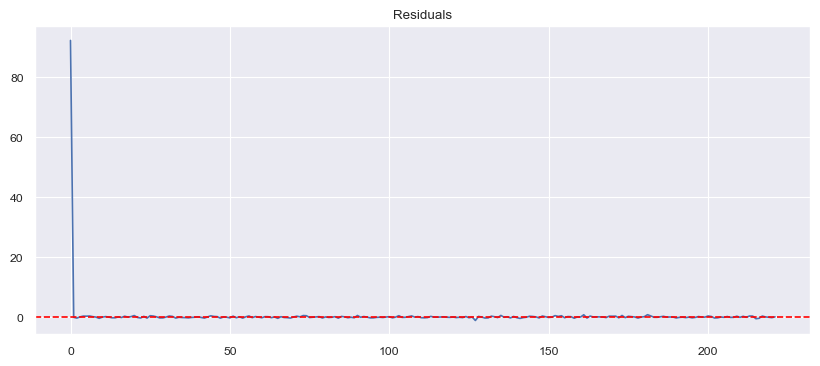

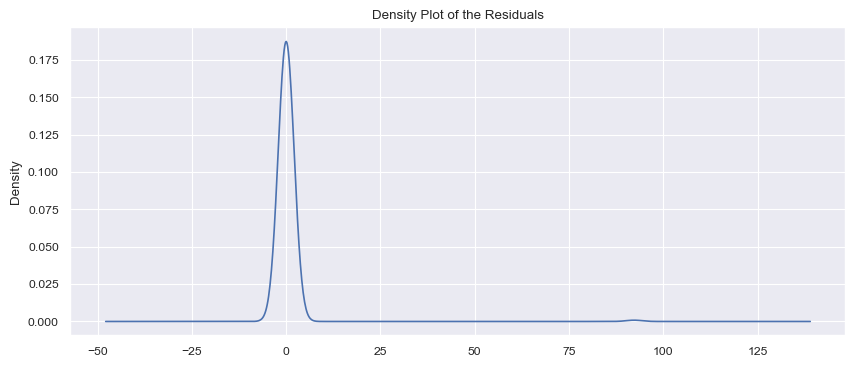

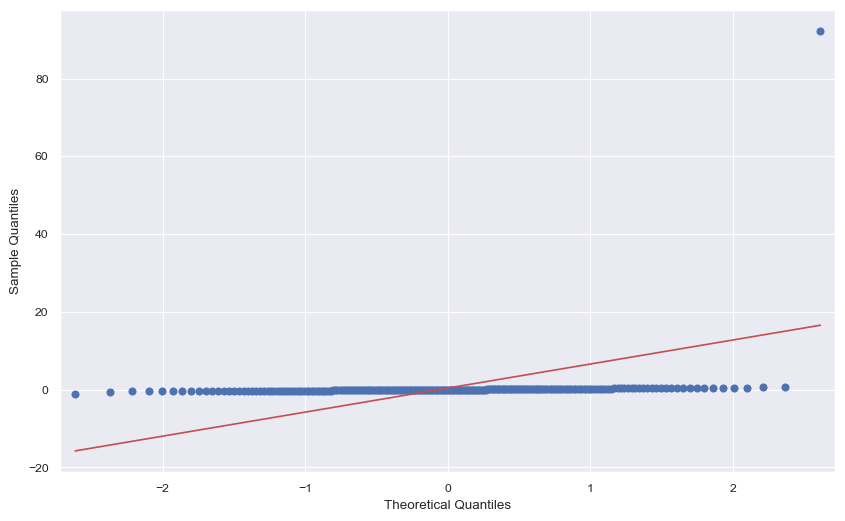

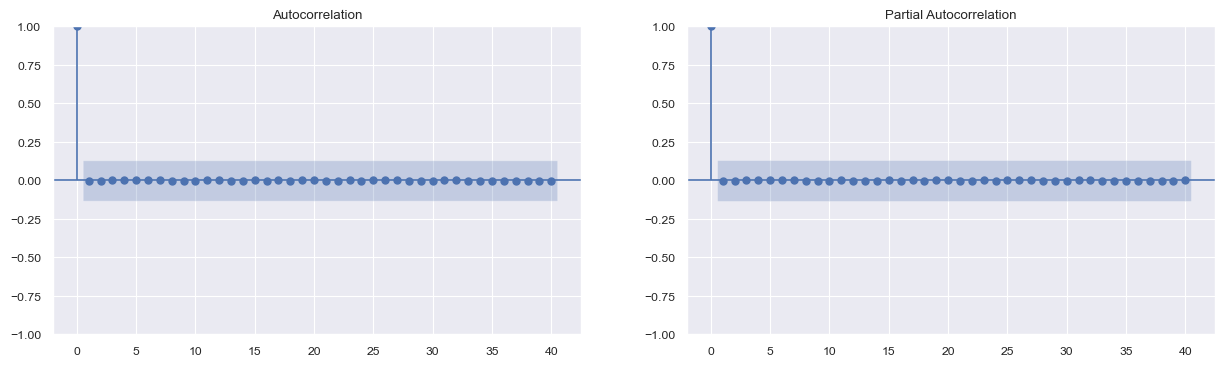

    lb_stat  lb_pvalue
10  0.01731        1.0
Test de Dickey-Fuller Aumentado:
ADF Statistic: -365.936205
p-value: 0.000000
Test de Shapiro-Wilk para normalidad:
ShapiroResult(statistic=0.057814588674630074, pvalue=1.1514657134585308e-31)


In [116]:
residuos = model_fit.resid

# Gráfico de los residuos
plt.figure(figsize=(10,4))
plt.plot(residuos)
plt.title('Residuals')
plt.axhline(0, linestyle='--', color='red')
plt.show()

# Gráfico de densidad de los residuos
plt.figure(figsize=(10,4))
residuos.plot(kind='kde')
plt.title('Density Plot of the Residuals')
plt.show()

# Gráfico Q-Q para normalidad
sm.qqplot(residuos, line='s')
plt.show()

# ACF y PACF de los residuos
fig, ax = plt.subplots(1,2, figsize=(15,4))
sm.graphics.tsa.plot_acf(residuos, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(residuos, lags=40, ax=ax[1])
plt.show()

# Prueba de Ljung-Box para autocorrelación
lb_test = acorr_ljungbox(residuos, lags=[10], return_df=True)
print(lb_test)

# Prueba de Dickey-Fuller para estacionariedad
adf_test = sm.tsa.stattools.adfuller(residuos)
print('Test de Dickey-Fuller Aumentado:')
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

# Si tienes el módulo 'scipy', puedes realizar pruebas de normalidad:
from scipy import stats
print('Test de Shapiro-Wilk para normalidad:')
print(stats.shapiro(residuos))

Teniendo en cuanta las graficas y puebas estaditicas, los  residuos no presentan autocorrelación significativa y son estacionarios, lo cual es positivo y sugiere que el modelo ha capturado adecuadamente las dinámicas de los datos.
Sin embargo, los residuos no parecen distribuirse normalmente.

### Forescast 

In [117]:
model = ARIMA(train, order=(0,1,0)) 
results = model.fit()
predictions = results.forecast(steps=len(test_2w))
print('Real:', test_2w)

Real: 222    91.443100
223    91.668602
224    91.810097
225    91.589897
226    91.679100
227    91.591904
228    91.521301
229    91.589897
230    91.555298
231    91.487999
232    91.640701
233    91.719704
234    92.025002
235    91.926300
236    92.144997
237    92.228401
238    92.370003
239    92.459801
240    92.379997
241    92.190598
242    92.111900
243    91.805000
244    91.730202
245    91.695000
246    91.900002
247    92.042999
248    92.095100
249    92.239601
Name: close, dtype: float64


In [118]:
print('vs. Predicho:',predictions)

vs. Predicho: 222    91.994003
223    91.994003
224    91.994003
225    91.994003
226    91.994003
227    91.994003
228    91.994003
229    91.994003
230    91.994003
231    91.994003
232    91.994003
233    91.994003
234    91.994003
235    91.994003
236    91.994003
237    91.994003
238    91.994003
239    91.994003
240    91.994003
241    91.994003
242    91.994003
243    91.994003
244    91.994003
245    91.994003
246    91.994003
247    91.994003
248    91.994003
249    91.994003
Name: predicted_mean, dtype: float64


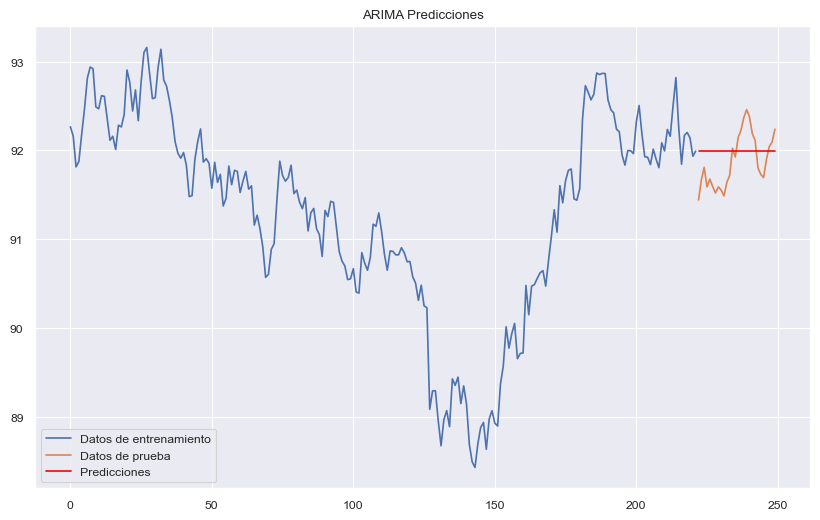

In [119]:
plt.figure(figsize=(10, 6))
plt.plot(train, label='Datos de entrenamiento')
plt.plot(test_2w, label='Datos de prueba')
plt.plot(test_2w.index, predictions, label='Predicciones', color='red')
plt.legend()
plt.title('ARIMA Predicciones')
plt.show()

In [120]:
mae = mean_absolute_error(test_2w, predictions)
mse = mean_squared_error(test_2w, predictions)
mape = mean_absolute_percentage_error(test_2w, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_2w, predictions)

# Imprimir métricas de evaluación
print(f'MAE (Error absoluto medio): {mae}')
print(f'MSE (Error cuadrático medio): {mse}')
print(f'MAPE (Error absoluto porcentual medio): {mape}')
print(f'RMSE (Raíz del error cuadrático medio): {rmse}')
print(f'R2 (Coeficiente de determinación): {r2}')

# Obtener información sobre el modelo
print(f'BIC (Criterio de Información Bayesiano): {results.bic}')
print(f'AIC (Criterio de Información de Akaike): {results.aic}')
print(f'HQIC (Criterio de Información Hannan-Quinn): {results.hqic}')

MAE (Error absoluto medio): 0.2820826939174107
MSE (Error cuadrático medio): 0.10079742904054001
MAPE (Error absoluto porcentual medio): 0.0030722730306930383
RMSE (Raíz del error cuadrático medio): 0.3174861084213607
R2 (Coeficiente de determinación): -0.1477594263173092
BIC (Criterio de Información Bayesiano): 21.6485087678596
AIC (Criterio de Información de Akaike): 18.250346066341848
HQIC (Criterio de Información Hannan-Quinn): 19.62246337677312


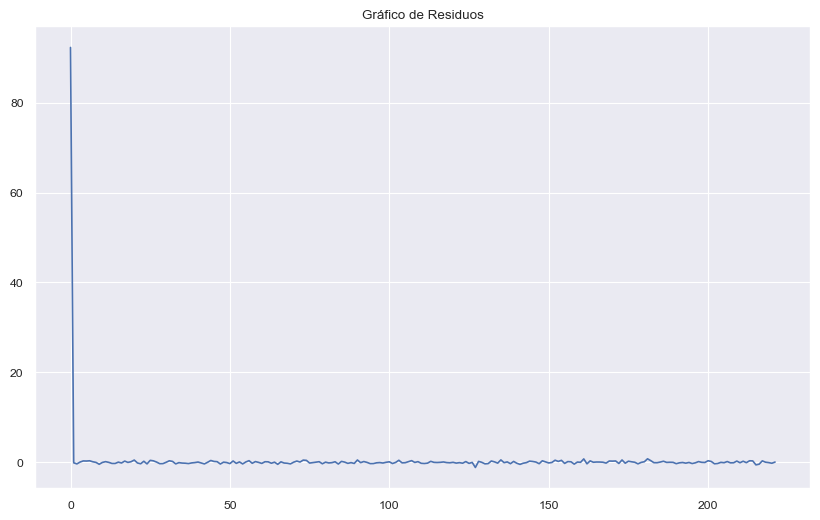

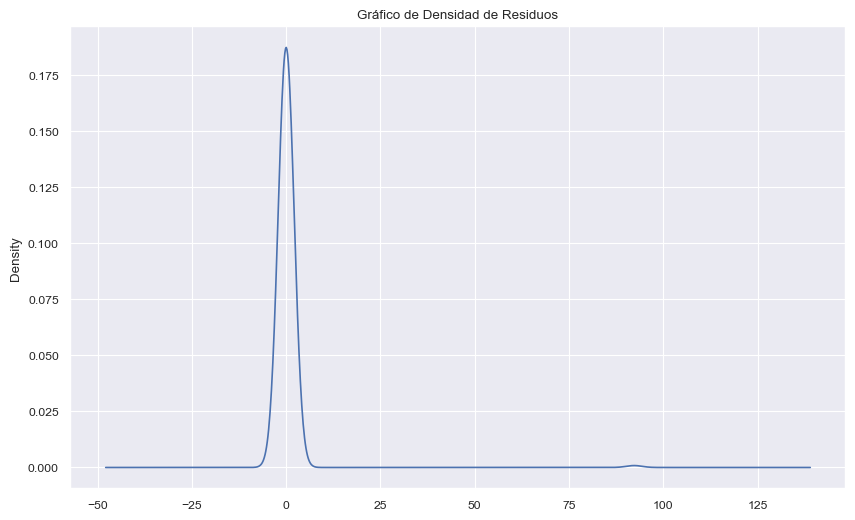

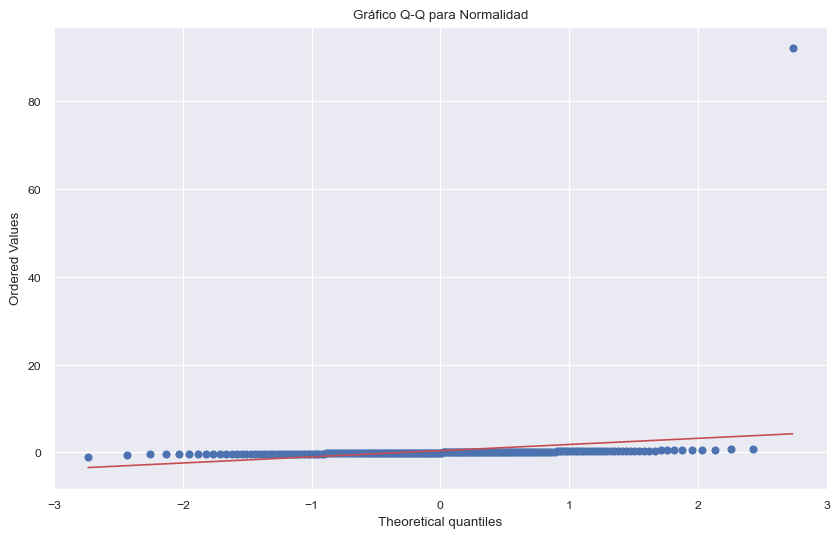

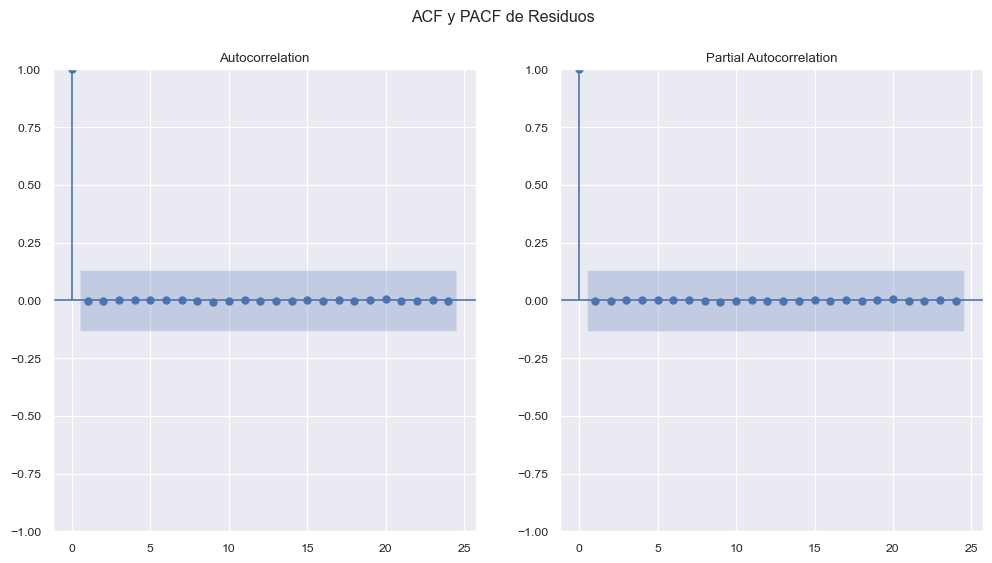

Estadístico de prueba Ljung-Box: lb_stat
p-value: lb_pvalue
Estadístico de prueba Dickey-Fuller: -365.93620509220403
p-value: 0.0
Valores críticos:
1%: -3.4602906385073884
5%: -2.874708679520702
10%: -2.573788599127782
p-value de la prueba de normalidad: 1.6485660855048558e-108


In [121]:
residuals = results.resid

# Gráfico de los residuos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Gráfico de Residuos')
plt.show()

# Gráfico de densidad de los residuos
plt.figure(figsize=(10, 6))
residuals.plot(kind='kde')
plt.title('Gráfico de Densidad de Residuos')
plt.show()

# Gráfico Q-Q para normalidad
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Gráfico Q-Q para Normalidad')
plt.show()

# ACF y PACF de los residuos
plt.figure(figsize=(12, 6))
plot_acf(residuals, ax=plt.subplot(121))
plot_pacf(residuals, ax=plt.subplot(122))
plt.suptitle('ACF y PACF de Residuos')
plt.show()

# Prueba de Ljung-Box para autocorrelación
lb_test_stat, lb_p_value = acorr_ljungbox(residuals, lags=[10])
print(f'Estadístico de prueba Ljung-Box: {lb_test_stat}')
print(f'p-value: {lb_p_value}')

# Prueba de Dickey-Fuller para estacionariedad
adf_test_stat, adf_p_value, _, _, adf_critical_values, _ = adfuller(residuals)
print(f'Estadístico de prueba Dickey-Fuller: {adf_test_stat}')
print(f'p-value: {adf_p_value}')
print('Valores críticos:')
for key, value in adf_critical_values.items():
    print(f'{key}: {value}')

# Prueba de normalidad
_, normality_p_value = stats.normaltest(residuals)
print(f'p-value de la prueba de normalidad: {normality_p_value}')

en este caso, los residuos de nuevo,  no muestran autocorrelación significativa y son estacionarios, y se observa que los residuos no siguen una distribución normal como lo compruba el valor del p valor en la prueba de normalidad

## Comparacón de Modelos
 el modelo de Rolling Forecast parece tener un rendimiento superior. Tiene errores más bajos en todas las métricas (MAE, MSE, RMSE y MAPE) y un R2 positivo, lo que indica que es más efectivo para capturar la varianza en los datos

## DECISIÓN FINAL:
 TENIENDO EN CUENTA QUE LAS MÉTRICAS DEL ROLLING FORECAST CON UNA VENTANA DE 28 DÍAS TIENEN MEJORES RESULTADOS Y SE AJUSTAN MEJOR AL COMPORTAMIENTO DE LOS DATOS, SE ELIGE ESTE COMO EL MEJOR MODELO.